#### Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score,LeaveOneOut,ShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier

import scratch as s

In [2]:
'''
guide = pandas.read_excel('bbdp/data/D20Mar2015a.xls')
dementia_labels = [row[0] for _,row in guide.iterrows() \
                   if row[2].__class__.__name__ == 'str' and 'Yes with Dementia' in row[2]]
df = pandas.read_excel('bbdp/data/D20Mar2015a.xls',sheetname='Data',index_col=0)

smell = df[['shri_case_num','stint','deathage','smell_reduced_or_absent']]#+['smell_%d' % q for q in range(1,41)]]
smell.insert(3,'dementia',[np.any([row[col_label]==2 for col_label in dementia_labels]) \
                           for row_label,row in df.iterrows()])
smell.insert(3,'test_age',df['deathage'] - df['stint'])

smell_test_key = pandas.read_excel('bbdp/data/GerkinSmithUPSITautopsy9_10_14.xlsx',sheetname='smellTestKey')
smell_test_key = smell_test_key['Correct answer']
smell_matrix = df[['smell_%d' % q for q in range(1,41)]].as_matrix()
for q in range(40):
    smell_matrix[:,q] = (smell_matrix[:,q] == smell_test_key[q])
smell.insert(3,'upsit_total',smell_matrix.sum(axis=1))
smell.rename(columns={'shri_case_num': 'Case ID'}, inplace=True)
''';

In [3]:
guide = pandas.read_excel('bbdp/data/D20Mar2015a.xls')
dementia_labels = [row[0] for _,row in guide.iterrows() \
                   if row[2].__class__.__name__ == 'str' and 'Yes with Dementia' in row[2]]
df = pandas.read_excel('bbdp/data/D20Mar2015a.xls',sheetname='Data',index_col=0)

pathological = df.iloc[:,4:25].drop('ipspp',1)
pathological = 1*(pathological > 0)
pathological = pathological.loc[:,pathological.sum()>0]

clinical = df.loc[:,['female','smell_reduced_or_absent']+['smell_%d' % q for q in range(1,41)]]
clinical['smell_reduced_or_absent'].fillna(0, inplace=True)
clinical['dementia'] = [np.any([row[col_label]==2 for col_label in dementia_labels]) \
                         for row_label,row in df.iterrows()]
clinical['test_age'] = df['deathage'] - df['stint']
for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        clinical['smell_%d%s' % (q,letter)] = clinical['smell_%d' % q]==(i+1)
    clinical.drop('smell_%d' % q,axis=1,inplace=True)

In [4]:
p = pathological
#assert p[(p.demunp>0) & (various dementias)].size == 0
assert p[(p.lbdins>0) & ((p.ilbd>0) | (p.dlbp>0) | (p.pddefined>0) | (p.parkismp>0))].size == 0
assert p[(p.ilbd>0) & ((p.ad>0) | (p.vascp>0) | (p.ftdpdefined>0) | \
                       (p.dlbp>0) | (p.pddefined>0) | (p.parkismp>0) | (p.pspp>0) | (p.cbdp>0))].size == 0
assert p[(p.parkismp>0) & ((p.dlbp>0) | (p.lbdins>0) | (p.ilbd>0) | \
                           (p.pddefined>0) | (p.pspp>0) | (p.cbdp>0))].size == 0

In [5]:
master = pathological.join(clinical)

In [6]:
from sklearn.ensemble import RandomForestClassifier
X = clinical.as_matrix().astype(float)
Y = pathological.as_matrix().astype(bool)

In [122]:
X1 = clinical.as_matrix().astype(float)
X2 = X[:,:4]
X3 = clinical[['female','test_age','dementia']].as_matrix().astype(float)
Xs = {'all':X1, 'total':X2, 'basic':X3}

In [8]:
Y_cv,p,p1,p0 = {}
for key,X in Xs.items():
    max_features = 40 if key=='all' else None
    rfc = RandomForestClassifier(n_estimators=50,max_features=max_features)
    Y_cv[key], p[key], p1[key], p0[key] = s.roc_data(X,Y,rfc,n_iter=25,test_size=0.1)

In [34]:
ps = s.build_p_frame(p0,p1,pathological,guide)
ps.head()

,Diagnosis,Predicted Probability,Outcome
0,AD,0.977588,--
1,AD,0.017547,--
2,AD,0.709118,--
3,AD,0.934757,--
4,AD,0.536117,--


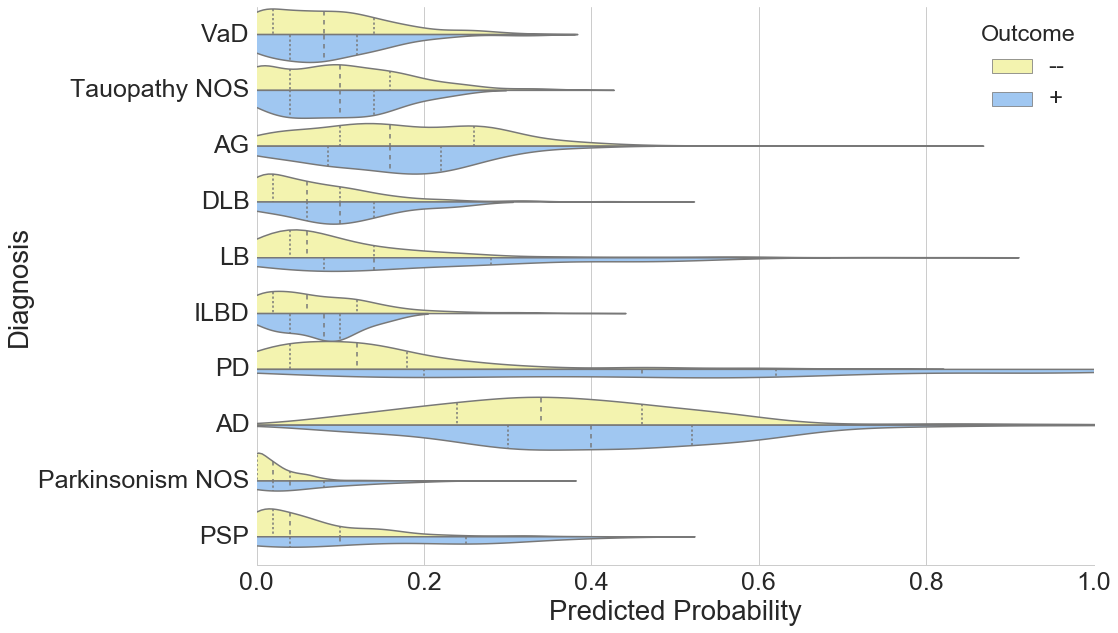

In [11]:
s.violin_roc(ps) # Make a plot showing probability densities of predicted probabilities 
                 # for cases with vs without the label.  

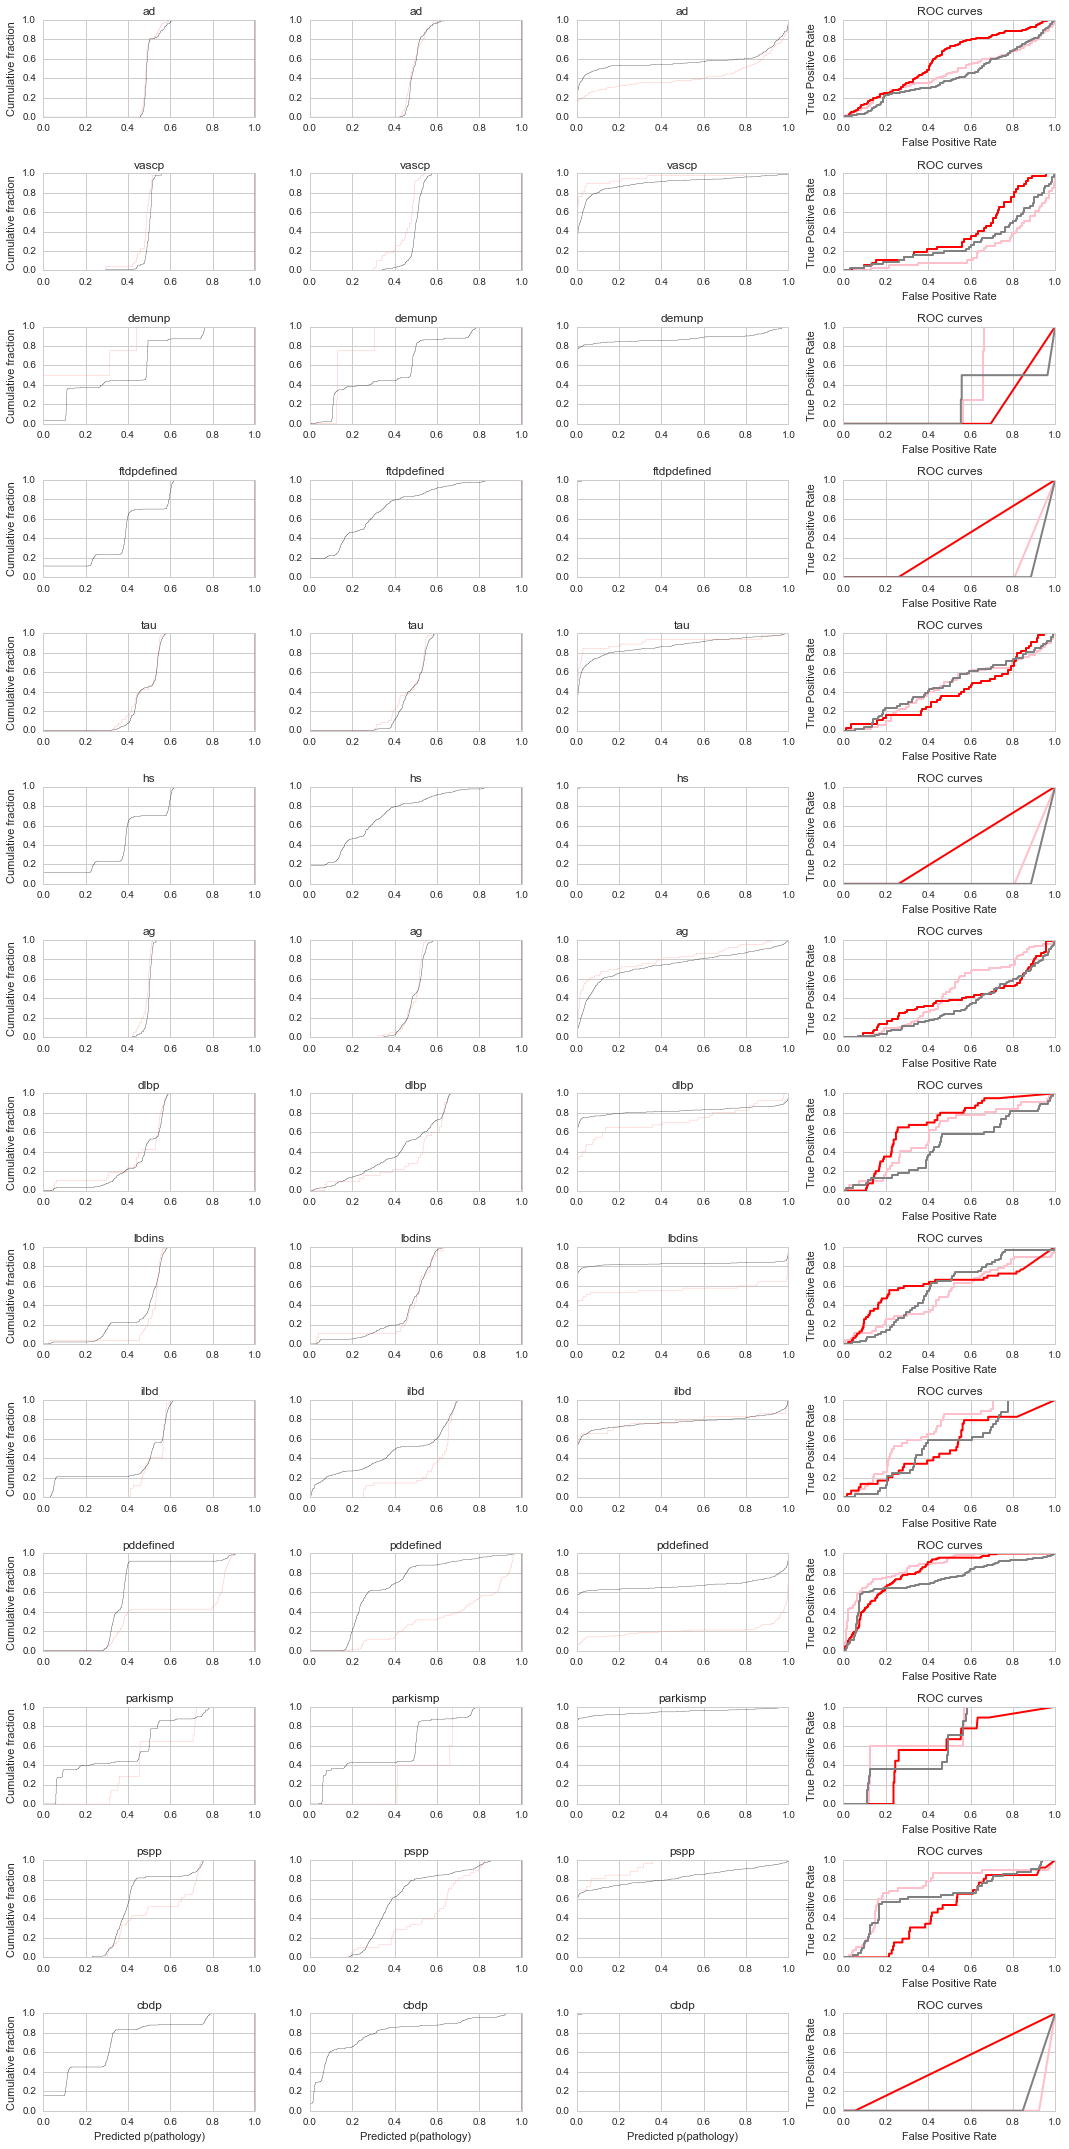

In [28]:
s.plot_roc_curves_with_ps(Y,Y_cv,Xs,p0,p1,p,pathological)

In [16]:
#from sklearn.calibration import CalibratedClassifierCV

In [123]:
Y_cv,p,p1,p0 = {},{},{},{}
for key,X in Xs.items():
    mnb = MultinomialNB(alpha=0.1,fit_prior=True)
    clf = OneVsRestClassifier(mnb)
    Y_cv[key], p[key], p1[key], p0[key] = s.roc_data(X,Y,clf,n_iter=None,test_size=None)

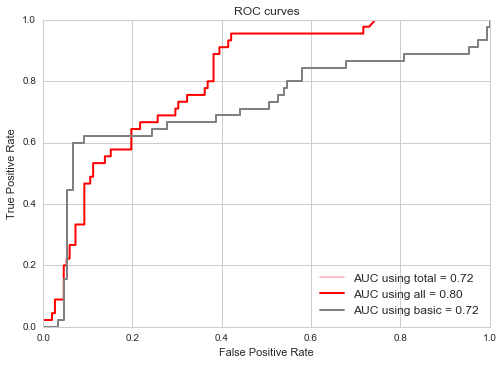

In [124]:
i=10
s.plot_roc_curves({key:Y_cv[key][i] for key in Xs.keys()},
                        {key:p[key][i] for key in Xs.keys()})

In [101]:
ps = s.build_p_frame(p0,p1,pathological,guide)
ps.head()

,Diagnosis,Predicted Probability,Outcome
0,AD,0.032925,--
1,AD,0.007982,--
2,AD,0.006948,--
3,AD,0.999674,--
4,AD,0.000672,--


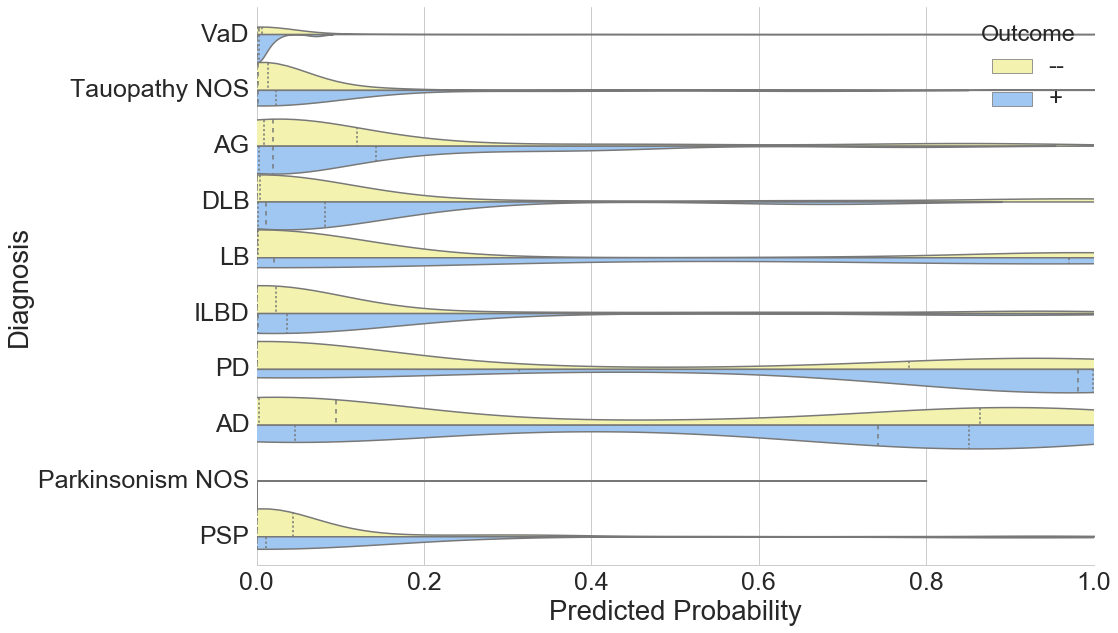

In [102]:
s.violin_roc(ps)

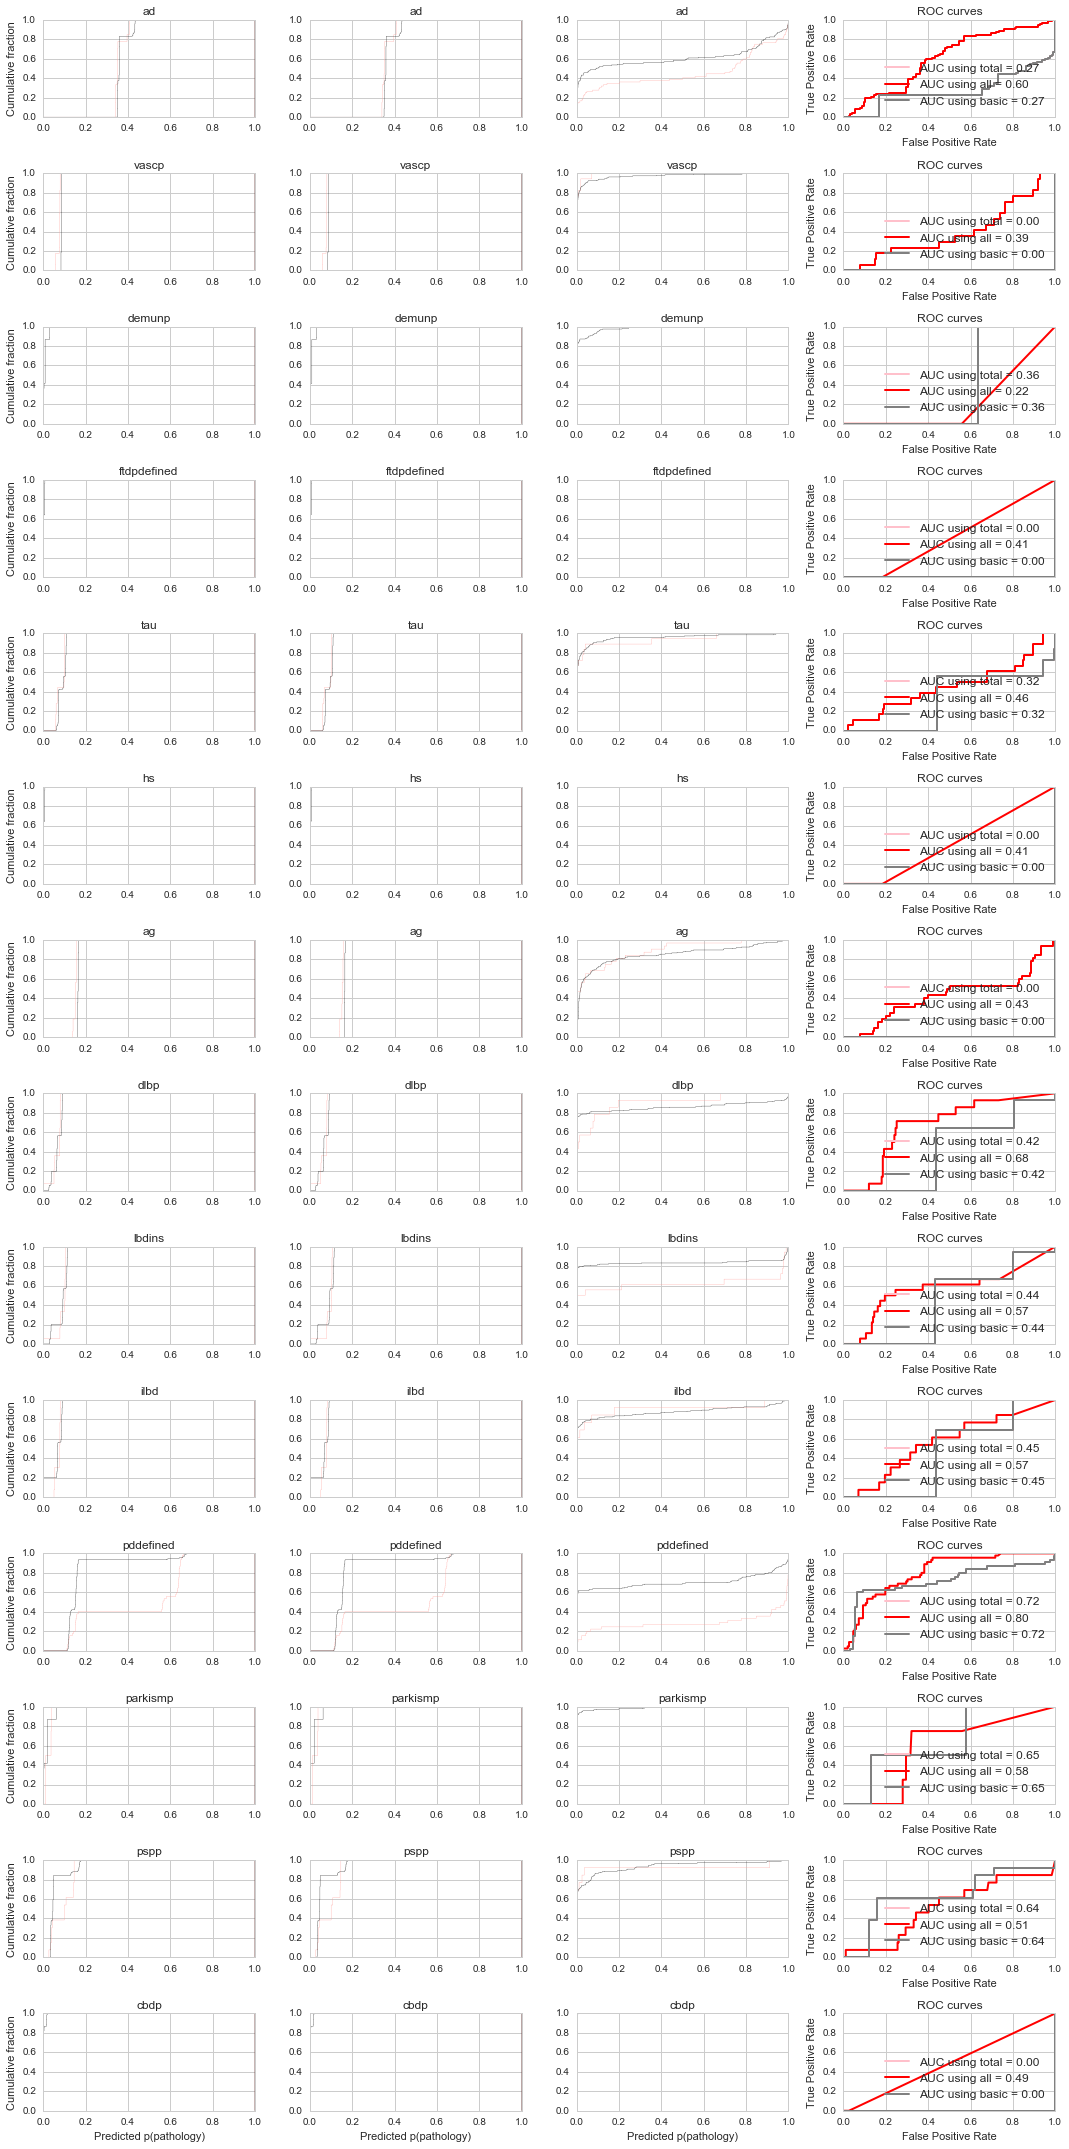

In [104]:
s.plot_roc_curves_with_ps(Y,Y_cv,Xs,p0,p1,p,pathological)

In [142]:
for i in range(14):
    print(pathological.columns.values[i])
    clf = RandomForestClassifier(n_estimators=100,max_features=None)
    for key in ['basic','total','all']:
        val = s.cross_validate(clf,Xs[key],Y[:,i],shuffle_split,key)

ad
Cross-validation accuracy for basic is 0.585
Cross-validation accuracy for total is 0.591
Cross-validation accuracy for all is 0.585
vascp
Cross-validation accuracy for basic is 0.859
Cross-validation accuracy for total is 0.858
Cross-validation accuracy for all is 0.906
demunp
Cross-validation accuracy for basic is 0.983
Cross-validation accuracy for total is 0.979
Cross-validation accuracy for all is 0.992
ftdpdefined
Cross-validation accuracy for basic is 0.990
Cross-validation accuracy for total is 0.992
Cross-validation accuracy for all is 0.993
tau
Cross-validation accuracy for basic is 0.854
Cross-validation accuracy for total is 0.873
Cross-validation accuracy for all is 0.894
hs
Cross-validation accuracy for basic is 0.990
Cross-validation accuracy for total is 0.993
Cross-validation accuracy for all is 0.997
ag
Cross-validation accuracy for basic is 0.754
Cross-validation accuracy for total is 0.736
Cross-validation accuracy for all is 0.822
dlbp
Cross-validation accuracy 